# 1. Extraction of features from segmentation data

This first part of the analysis quantifies several features of the cells in 2D (analysis of each section of the stack individually): area of all segmented organelles per cell, number of mitochondria and nucleus, and shape of cell, mitochondria and nuclei. Shape is quantified as:

Aspect ratio: ratio between the longest and shortest sides of the bbox. The bbox is the minimal rectangle that contains the whole object in terms of its coordenates.
Roundness: ratio between the object´s area and its longest side (FH) of the bbox:
$$roundness = \frac{4*A}{\pi*F_{H}^{2}}$$

## Export segmentation
The script uses segmentation files exported from Vast Lite using the following conditions:

- Multi-tile stack
- Mip level: 0
- Export segmentation as ".png"
- 8bit/px
- Collapsed labels as in current view
- Export currently selected label (and select each segmen layer for each organelle manually).

Each of the segments for each organelle has to be stored in a different folder and the name of the individual files must contain ".vsseg_export_s". After "s", it detects the number of the section using the following, so that if the section has two digits zfill(2) and if it has three digits zfill(3):

- self.file = r'*export_s{}*'.format(str(sl_num).zfill(...))
For the tile size: recommended to use a divisible number to the total height and width of the section.

In case of changing the tile size: need to change the numbers on Cells.py (in patchsize inside of the function definition get_imageshape) and the number of tiles that will be created from that into self.imageshape (first two values).
For example: if for a image of 1024x1024 the tile size selected is 256x256, it would create four tiles, so:

- patchsize=(256,256)
- self.imageshape = (4,4,*patchsize)

In [1]:
from Cells import Cells
from MGFeatures import *
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import napari
from tifffile import imsave
import skimage.measure
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

C:\Users\Gast-User\.conda\envs\tcell\lib\site-packages\napari\_qt\__init__.py:50: UserWarning: 

IMPORTANT:
You are using QT version 5.9.7, but version 5.15.7 was also found in your environment.
This usually happens when you 'conda install' something that also depends on PyQt
*after* you have pip installed napari (such as jupyter notebook).
You will likely run into problems and should create a fresh environment.
If you want to install conda packages into the same environment as napari,
please add conda-forge to your channels: https://conda-forge.org

  warn(message=warn_message)
C:\Users\Gast-User\.conda\envs\tcell\lib\site-packages\numba\core\decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [81]:
# TO-DO: include this definition in Cells.py or MGFeatures.py

def get_area(labels, labels_list): 
    areas = []
    for i in labels_list:
        area = np.count_nonzero(labels == i)
        areas.append(area)
    areas = np.array(areas)
    return areas

In [2]:
folder = r'Y:\MS293_Shun_Immunogold_030523\Segmentation\cell_final'
heterochromatin_folder = r'Y:\MS293_Shun_Immunogold_030523\Segmentation\heterochromatin_final'
gold_folder = r'Y:\MS293_Shun_Immunogold_030523\Segmentation\gold_final'
lysosomes_folder = r'Y:\MS293_Shun_Immunogold_030523\Segmentation\lysosome_final'
mitochondria_folder = r'Y:\MS293_Shun_Immunogold_030523\Segmentation\mitochondria_final'
nucleus_folder = r'Y:\MS293_Shun_Immunogold_030523\Segmentation\nucleus_final'
ER_folder = r'Y:\MS293_Shun_Immunogold_030523\Segmentation\er_final'
golgi_folder = r'Y:\MS293_Shun_Immunogold_030523\Segmentation\golgi_final'

##  tcell_properties function

The following functionautomatically extracts several features of the segments per label, being here a label one cell in each plane. The code is divided into different functions:

- #### A. Label cells

This part of the code creates the labels for the cell segment. It runs over the i, which is the section number. The functions indicated: 'get_imageshape()', 'img_from_tiles()', 'label_cells()' are described in Cells.py. These functions reconstruct the whole image from the tiles created for the segmentation export and detects the connected elements to label the individual cells. 'cell_labels' is an array that can be visualized with napari.

- #### B: Label organelles

This part of the code creates individual labels for the organelles, but they are dependent of the cell label via the mask_it() function. This function returns an array np.int8, in which the information is the number of the label of the cell.
For example, if a cell with label number 1 has two mitochondria, both of these mitochondria will be labeled 1.

- #### C: Connected labels

The skimage.measure.label() with connectivity=2 creates labelling of the organelles in a different way, so that two mitochondria present in the same cell contain a different label. This is not necessary for the cell labels, but it changes the data to an array of np.int64 in all cases.

- #### D: Dataframe with cell, mitochondria and nucleus coordinates

For the cell, mitochondria and nucleus labels, a pandas data frame is created that contains per label the coordinates of the bbox, stored as the minimum and maximum values of x and y axis.

- #### E. Assign mitochondria and nucleus to cell coordinates

The loop assigns the label of the cell to which each organelle belongs and stores it as 'id_cell', so that the organelles that belong to the same cell can later be grouped and extracted the mean values.

- #### F. Calculate properties per cell

Using the coordinates of each label we calculate the aspect ratio and roundness. For the aspect ratio, the largest and smallest side of the bbox are calculated as the maximum and minimum difference, respectively, between the row and column values. 

- #### G. Add properties to data frame

All properties are added to an empty data frame. In the case of properties related to mitochondria and nucleus, the mean properties of the organelles is calculated per cell, by grouping them by their cell id.

In [24]:
def tcell_properties(i):
    #propertiesall  = pd.DataFrame()
    # A. Label cells
    cell = Cells(i)
    imageshape = cell.get_imageshape(folder) #TODO: this step is redundant! Fix in cells
    cell_image = cell.img_from_tiles(folder)
    cell_labels = cell.label_cells(cell_image)
    labels_list = np.unique(cell_labels)[1:]
    
    # B. label organelles
    heterochromatin_labels = mask_it(cell_labels, cell.img_from_tiles(heterochromatin_folder))
    lysosomes_labels = mask_it(cell_labels, cell.img_from_tiles(lysosomes_folder))
    mitochondria_labels = mask_it(cell_labels, cell.img_from_tiles(mitochondria_folder))
    nucleus_labels = mask_it(cell_labels, cell.img_from_tiles(nucleus_folder))
    gold_labels = mask_it(cell_labels, cell.img_from_tiles(gold_folder))
    golgi_labels = mask_it(cell_labels, cell.img_from_tiles(golgi_folder))
    ER = cell.img_from_tiles(ER_folder)
    
    # C. Connected labels
    cell_label = skimage.measure.label(cell_labels, connectivity=2)
    mito_label = skimage.measure.label(mitochondria_labels, connectivity=2)
    nuc_label = skimage.measure.label(nucleus_labels, connectivity=2)
    
    #D. Dataframe with cell, mitochondria and nucleus coordinates
    cell_coord = []
    coord_cell = pd.DataFrame()
    region = regionprops(cell_label)
    for r in region:
        min_row, min_col, max_row, max_col = r.bbox
        cell_coord.append((min_row, max_row, min_col, max_col))
    coord_cell = pd.DataFrame(cell_coord, columns = ["min_row","max_row", "min_col", "max_col"])
   
    mito_coord = []
    coord_mito = pd.DataFrame()
    region = regionprops(mito_label)
    for r in region:
        min_row, min_col, max_row, max_col = r.bbox
        mito_coord.append((min_row, min_col, max_row, max_col))
    coord_mito = pd.DataFrame(mito_coord, columns = ["min_row", "min_col", "max_row", "max_col"])
    
    nuc_coord = []
    coord_nuc = pd.DataFrame()
    region = regionprops(nuc_label)
    for r in region:
        min_row, min_col, max_row, max_col = r.bbox
        nuc_coord.append((min_row, min_col, max_row, max_col))
    coord_nuc = pd.DataFrame(nuc_coord, columns = ["min_row", "min_col", "max_row", "max_col"])
    
    #E. Assign mitochondria and nucleus to cell coordinates
    coord_mito['id_cell'] = 0
    for x in range(len(coord_cell)):
        for y in range(len(coord_mito)):
            if (coord_mito["min_row"][y] >= coord_cell["min_row"][x]  and coord_mito["max_row"][y] <= coord_cell["max_row"][x]) and (coord_mito["min_col"][y] >= coord_cell["min_col"][x]and coord_mito["max_col"][y] <= coord_cell["max_col"][x]):
                coord_mito['id_cell'][y] = x
    
    coord_nuc['id_cell'] = 0
    for y in range(len(coord_nuc)):
        for x in range(len(coord_cell)):
            if (coord_nuc["min_row"][y] >= coord_cell["min_row"][x]  and coord_nuc["max_row"][y] <= coord_cell["max_row"][x]) and (coord_nuc["min_col"][y] >= coord_cell["min_col"][x]and coord_nuc["max_col"][y] <= coord_cell["max_col"][x]):
                coord_nuc['id_cell'][y] = x
    
    #F. Calculate properties per cell
    #F1. Mitochondria
    coord_mito['mito_large'] = 0
    coord_mito['mito_small'] = 0
    for y in range(len(coord_mito)):
        D = max(coord_mito['max_row'][y] - coord_mito['min_row'][y], coord_mito['max_col'][y] - coord_mito['min_col'][y])
        coord_mito['mito_large'][y] = D
        d = min(coord_mito['max_row'][y] - coord_mito['min_row'][y], coord_mito['max_col'][y] - coord_mito['min_col'][y])
        coord_mito['mito_small'][y] = d
    coord_mito['mito_aspect'] = coord_mito['mito_small']/coord_mito['mito_large']
    mito_list = np.unique(mito_label)[1:]
    coord_mito['mito_area'] = get_area(mito_label, mito_list)
    coord_mito['mito_roundness'] = (4*coord_mito['mito_area'])/(np.pi*(coord_mito['mito_large']**2))
    
    #F2. Nucleus
    coord_nuc['nuc_large'] = 0
    coord_nuc['nuc_small'] = 0
    for y in range(len(coord_nuc)):
        M = max(coord_nuc['max_row'][y] - coord_nuc['min_row'][y], coord_nuc['max_col'][y] - coord_nuc['min_col'][y])
        coord_nuc['nuc_large'][y] = M
        m = min(coord_nuc['max_row'][y] - coord_nuc['min_row'][y], coord_nuc['max_col'][y] - coord_nuc['min_col'][y])
        coord_nuc['nuc_small'][y] = m
    coord_nuc['nuc_aspect'] = coord_nuc['nuc_small']/coord_nuc['nuc_large']
    nuc_list = np.unique(nuc_label)[1:]
    coord_nuc['nuc_area'] =  get_area(nuc_label, nuc_list)
    coord_nuc['nuc_roundness'] = (4*coord_nuc['nuc_area'])/(np.pi*(coord_nuc['nuc_large']**2))
    
    #F3. Cell
    coord_cell['cell_large'] = 0
    coord_cell['cell_small'] = 0
    for y in range(len(coord_cell)):
        D = max(coord_cell['max_row'][y] - coord_cell['min_row'][y], coord_cell['max_col'][y] - coord_cell['min_col'][y])
        coord_cell['cell_large'][y] = D
        d = min(coord_cell['max_row'][y] - coord_cell['min_row'][y], coord_cell['max_col'][y] - coord_cell['min_col'][y])
        coord_cell['cell_small'][y] = d
    coord_cell['cell_aspect'] = coord_cell['cell_small']/coord_cell['cell_large']
    
    #G. Add to properties data frame
    properties = pd.DataFrame()
    cell_list = np.unique(cell_labels)[1:]
    properties['cell_area'] = get_area(cell_labels, cell_list)
    properties['cell_aspect'] = coord_cell['cell_aspect']
    properties['cell_roundness'] = (4*properties['cell_area'])/(np.pi*(coord_cell['cell_large']**2))
    properties['number_mito'] = coord_mito.groupby(['id_cell']).size()
    properties['mean_mito_aspect'] = coord_mito.groupby(['id_cell'])['mito_aspect'].mean()
    properties['std_mito_aspect'] = coord_mito.groupby(['id_cell'])['mito_aspect'].std()
    properties['mean_mito_area'] = coord_mito.groupby(['id_cell'])['mito_area'].mean()
    properties['std_mito_area'] = coord_mito.groupby(['id_cell'])['mito_area'].std()
    properties['mean_mito_roundness'] = coord_mito.groupby(['id_cell'])['mito_roundness'].mean()
    properties['std_mito_roundness'] = coord_mito.groupby(['id_cell'])['mito_roundness'].std()
    properties['sum_mito_area'] = coord_mito.groupby(['id_cell'])['mito_area'].sum()
    properties['number_nuc'] = coord_nuc.groupby(['id_cell']).size()
    properties['mean_nuc_aspect'] = coord_nuc.groupby(['id_cell'])['nuc_aspect'].mean()
    properties['std_nuc_aspect'] = coord_nuc.groupby(['id_cell'])['nuc_aspect'].std()
    properties['mean_nuc_area'] = coord_nuc.groupby(['id_cell'])['nuc_area'].mean()
    properties['std_nuc_area'] = coord_nuc.groupby(['id_cell'])['nuc_area'].std()
    properties['mean_nuc_roundness'] = coord_nuc.groupby(['id_cell'])['nuc_roundness'].mean()
    properties['std_nuc_roundness'] = coord_nuc.groupby(['id_cell'])['nuc_roundness'].std()
    properties['std_nuc_area'] = coord_nuc.groupby(['id_cell'])['nuc_area'].std()
    properties['lysosomal_area'] = get_area(lysosomes_labels, labels_list)
    properties['heterochromatin_area'] = get_area(heterochromatin_labels, labels_list)
    properties['gold_area'] = get_area(gold_labels, labels_list)
    properties['nucleus_area'] = get_area(nucleus_labels, labels_list)
    properties['golgi_area'] = get_area(golgi_labels, labels_list)
    properties['cytoplasm_area'] = properties['cell_area'] - properties['nucleus_area']
    properties['ER_lengths'] = ER_length(ER, cell_labels)
    properties['sl_num'] = np.array([i]*len(labels_list))
    properties['x1'] = coord_cell['min_row']
    properties['x2'] = coord_cell['max_row']
    properties['y1'] = coord_cell['min_col']
    properties['y2'] = coord_cell['max_col']
    properties= properties.fillna(0)
    #propertiesall = propertiesall.append(properties)
    return properties

## Running the tcell_properties function in parallel
In order to make the process faster, the for loop to run each section using this function is achieved by running them in parallel. The nslices that can run in parallel in each case will depend on the number of cores of the pc and the total number in the range in the station´s RAM.

In [28]:
start_time = time.time()
nslices = 6
properties0_5 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(5))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Elapsed time:  755.4881026744843


[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed: 12.6min finished


In [29]:
propertiessum0_5 = pd.DataFrame()
for i in range(5):
    propertiessum0_5= propertiessum0_5.append(properties0_5[i]) 
propertiessum0_5.to_excel("tcell_properties_0_5_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3148227588.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum0_5= propertiessum0_5.append(properties0_5[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3148227588.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum0_5= propertiessum0_5.append(properties0_5[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3148227588.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum0_5= propertiessum0_5.append(properties0_5[i])


In [30]:
start_time = time.time()
nslices = 5
properties5_10 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(5,10))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 12.3min remaining: 18.4min


Elapsed time:  793.2934260368347


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 13.2min finished


In [31]:
propertiessum5_10 = pd.DataFrame()
for i in range(5):
    propertiessum5_10= propertiessum5_10.append(properties5_10[i]) 
propertiessum5_10.to_excel("tcell_properties_5_10_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2475896860.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum5_10= propertiessum5_10.append(properties5_10[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2475896860.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum5_10= propertiessum5_10.append(properties5_10[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2475896860.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum5_10= propertiessum5_10.append(properties5_10[i])


In [32]:
start_time = time.time()
nslices = 5
properties10_15 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(10,15))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 12.0min remaining: 18.0min


Elapsed time:  756.0928130149841


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 12.6min finished


In [33]:
propertiessum10_15 = pd.DataFrame()
for i in range(5):
    propertiessum10_15= propertiessum10_15.append(properties10_15[i]) 
propertiessum10_15.to_excel("tcell_properties_10_15_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2271224832.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum10_15= propertiessum10_15.append(properties10_15[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2271224832.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum10_15= propertiessum10_15.append(properties10_15[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2271224832.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum10_15= propertiessum10_15.append(properties10_15[i])


In [34]:
start_time = time.time()
nslices = 5
properties15_20 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(15,20))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 11.8min remaining: 17.7min


Elapsed time:  762.3302969932556


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 12.7min finished


In [35]:
propertiessum15_20 = pd.DataFrame()
for i in range(5):
    propertiessum15_20= propertiessum15_20.append(properties15_20[i]) 
propertiessum15_20.to_excel("tcell_properties_15_20_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3141150476.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum15_20= propertiessum15_20.append(properties15_20[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3141150476.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum15_20= propertiessum15_20.append(properties15_20[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3141150476.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum15_20= propertiessum15_20.append(properties15_20[i])


In [36]:
start_time = time.time()
nslices = 5
properties20_25 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(20,25))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 15.0min remaining: 22.6min


Elapsed time:  1100.758444070816


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 18.3min finished


In [37]:
propertiessum20_25 = pd.DataFrame()
for i in range(5):
    propertiessum20_25= propertiessum20_25.append(properties20_25[i]) 
propertiessum20_25.to_excel("tcell_properties_20_25_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2342377966.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum20_25= propertiessum20_25.append(properties20_25[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2342377966.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum20_25= propertiessum20_25.append(properties20_25[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2342377966.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum20_25= propertiessum20_25.append(properties20_25[i])


## Start from here

In [38]:
start_time = time.time()
nslices = 5
properties25_30 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(25,30))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 17.0min remaining: 25.5min


Elapsed time:  2273.3401618003845


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 37.9min finished


In [39]:
propertiessum25_30 = pd.DataFrame()
for i in range(5):
    propertiessum25_30= propertiessum25_30.append(properties25_30[i]) 
propertiessum25_30.to_excel("tcell_properties_25_30_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3834351105.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum25_30= propertiessum25_30.append(properties25_30[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3834351105.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum25_30= propertiessum25_30.append(properties25_30[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3834351105.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum25_30= propertiessum25_30.append(properties25_30[i])


In [40]:
start_time = time.time()
nslices = 5
properties30_35 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(30,35))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 16.0min remaining: 24.0min


Elapsed time:  1033.7929470539093


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 17.2min finished


In [41]:
propertiessum30_35 = pd.DataFrame()
for i in range(5):
    propertiessum30_35= propertiessum30_35.append(properties30_35[i]) 
propertiessum30_35.to_excel("tcell_properties_30_35_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\1325398368.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum30_35= propertiessum30_35.append(properties30_35[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\1325398368.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum30_35= propertiessum30_35.append(properties30_35[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\1325398368.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum30_35= propertiessum30_35.append(properties30_35[i])


In [42]:
start_time = time.time()
nslices = 5
properties35_40 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(35,40))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 14.7min remaining: 22.1min


Elapsed time:  1010.8453989028931


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 16.8min finished


In [43]:
propertiessum35_40 = pd.DataFrame()
for i in range(5):
    propertiessum35_40= propertiessum35_40.append(properties35_40[i]) 
propertiessum35_40.to_excel("tcell_properties_35_40_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2982677200.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum35_40= propertiessum35_40.append(properties35_40[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2982677200.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum35_40= propertiessum35_40.append(properties35_40[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2982677200.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum35_40= propertiessum35_40.append(properties35_40[i])


In [44]:
start_time = time.time()
nslices = 5
properties40_45 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(40,45))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 11.0min remaining: 16.4min


Elapsed time:  830.3272843360901


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 13.8min finished


In [45]:
propertiessum40_45 = pd.DataFrame()
for i in range(5):
    propertiessum40_45= propertiessum40_45.append(properties40_45[i]) 
propertiessum40_45.to_excel("tcell_properties_40_45_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\68150944.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum40_45= propertiessum40_45.append(properties40_45[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\68150944.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum40_45= propertiessum40_45.append(properties40_45[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\68150944.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum40_45= propertiessum40_45.append(properties40_45[i])


In [46]:
start_time = time.time()
nslices = 5
properties45_50 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(45,50))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 10.8min remaining: 16.1min


Elapsed time:  884.3557393550873


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 14.7min finished


In [47]:
propertiessum45_50 = pd.DataFrame()
for i in range(5):
    propertiessum45_50= propertiessum45_50.append(properties45_50[i]) 
propertiessum45_50.to_excel("tcell_properties_45_50_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\4031793049.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum45_50= propertiessum45_50.append(properties45_50[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\4031793049.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum45_50= propertiessum45_50.append(properties45_50[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\4031793049.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum45_50= propertiessum45_50.append(properties45_50[i])


In [48]:
start_time = time.time()
nslices = 5
properties50_55 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(50,55))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  8.3min remaining: 12.5min


Elapsed time:  547.1043720245361


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  9.1min finished


In [49]:
propertiessum50_55 = pd.DataFrame()
for i in range(5):
    propertiessum50_55= propertiessum50_55.append(properties50_55[i]) 
propertiessum50_55.to_excel("tcell_properties_50_55_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3842153167.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum50_55= propertiessum50_55.append(properties50_55[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3842153167.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum50_55= propertiessum50_55.append(properties50_55[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3842153167.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum50_55= propertiessum50_55.append(properties50_55[i])


In [50]:
start_time = time.time()
nslices = 5
properties55_60 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(55,60))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  7.7min remaining: 11.6min


Elapsed time:  498.0967013835907


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  8.3min finished


In [51]:
propertiessum55_60 = pd.DataFrame()
for i in range(5):
    propertiessum55_60= propertiessum55_60.append(properties55_60[i]) 
propertiessum55_60.to_excel("tcell_properties_55_60_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\349559836.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum55_60= propertiessum55_60.append(properties55_60[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\349559836.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum55_60= propertiessum55_60.append(properties55_60[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\349559836.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum55_60= propertiessum55_60.append(properties55_60[i])


In [52]:
start_time = time.time()
nslices = 5
properties60_65 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(60,65))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  9.3min remaining: 13.9min


Elapsed time:  1010.070415019989


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 16.8min finished


In [53]:
propertiessum60_65 = pd.DataFrame()
for i in range(5):
    propertiessum60_65= propertiessum60_65.append(properties60_65[i]) 
propertiessum60_65.to_excel("tcell_properties_60_65_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\1703037554.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum60_65= propertiessum60_65.append(properties60_65[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\1703037554.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum60_65= propertiessum60_65.append(properties60_65[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\1703037554.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum60_65= propertiessum60_65.append(properties60_65[i])


In [54]:
start_time = time.time()
nslices = 5
properties65_70 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(65,70))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  8.5min remaining: 12.7min


Elapsed time:  523.7065906524658


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  8.7min finished


In [55]:
propertiessum65_70 = pd.DataFrame()
for i in range(5):
    propertiessum65_70= propertiessum65_70.append(properties65_70[i]) 
propertiessum65_70.to_excel("tcell_properties_65_70_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3071563664.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum65_70= propertiessum65_70.append(properties65_70[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3071563664.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum65_70= propertiessum65_70.append(properties65_70[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3071563664.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum65_70= propertiessum65_70.append(properties65_70[i])


In [56]:
start_time = time.time()
nslices = 5
properties70_75 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(70,75))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  8.0min remaining: 12.0min


Elapsed time:  826.3286859989166


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 13.8min finished


In [57]:
propertiessum70_75 = pd.DataFrame()
for i in range(5):
    propertiessum70_75= propertiessum70_75.append(properties70_75[i]) 
propertiessum70_75.to_excel("tcell_properties_70_75_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2007279074.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum70_75= propertiessum70_75.append(properties70_75[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2007279074.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum70_75= propertiessum70_75.append(properties70_75[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2007279074.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum70_75= propertiessum70_75.append(properties70_75[i])


In [58]:
start_time = time.time()
nslices = 5
properties75_80 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(75,80))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  7.2min remaining: 10.8min


Elapsed time:  575.0544173717499


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  9.6min finished


In [59]:
propertiessum75_80 = pd.DataFrame()
for i in range(5):
    propertiessum75_80= propertiessum75_80.append(properties75_80[i]) 
propertiessum75_80.to_excel("tcell_properties_75_80_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2508754192.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum75_80= propertiessum75_80.append(properties75_80[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2508754192.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum75_80= propertiessum75_80.append(properties75_80[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2508754192.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum75_80= propertiessum75_80.append(properties75_80[i])


In [60]:
start_time = time.time()
nslices = 5
properties80_85 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(80,85))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  6.9min remaining: 10.3min


Elapsed time:  471.9792425632477


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  7.9min finished


In [61]:
propertiessum80_85 = pd.DataFrame()
for i in range(5):
    propertiessum80_85= propertiessum80_85.append(properties80_85[i]) 
propertiessum80_85.to_excel("tcell_properties_80_85_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3434598011.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum80_85= propertiessum80_85.append(properties80_85[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3434598011.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum80_85= propertiessum80_85.append(properties80_85[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3434598011.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum80_85= propertiessum80_85.append(properties80_85[i])


In [62]:
start_time = time.time()
nslices = 5
properties85_90 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(85,90))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  7.4min remaining: 11.2min


Elapsed time:  477.3251383304596


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  8.0min finished


In [63]:
propertiessum85_90 = pd.DataFrame()
for i in range(5):
    propertiessum85_90= propertiessum85_90.append(properties85_90[i]) 
propertiessum85_90.to_excel("tcell_properties_85_90_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3558146674.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum85_90= propertiessum85_90.append(properties85_90[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3558146674.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum85_90= propertiessum85_90.append(properties85_90[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3558146674.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum85_90= propertiessum85_90.append(properties85_90[i])


In [64]:
start_time = time.time()
nslices = 5
properties90_95 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(90,95))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  7.2min remaining: 10.8min


Elapsed time:  526.2716972827911


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  8.8min finished


In [65]:
propertiessum90_95 = pd.DataFrame()
for i in range(5):
    propertiessum90_95= propertiessum90_95.append(properties90_95[i]) 
propertiessum90_95.to_excel("tcell_properties_90_95_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2956590738.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum90_95= propertiessum90_95.append(properties90_95[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2956590738.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum90_95= propertiessum90_95.append(properties90_95[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2956590738.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum90_95= propertiessum90_95.append(properties90_95[i])


In [66]:
start_time = time.time()
nslices = 5
properties95_100 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(95,100))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  6.6min remaining:  9.9min


Elapsed time:  406.1328525543213


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  6.8min finished


In [67]:
propertiessum95_100 = pd.DataFrame()
for i in range(5):
    propertiessum95_100= propertiessum95_100.append(properties95_100[i]) 
propertiessum95_100.to_excel("tcell_properties_95_100_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3830063535.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum95_100= propertiessum95_100.append(properties95_100[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3830063535.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum95_100= propertiessum95_100.append(properties95_100[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3830063535.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum95_100= propertiessum95_100.append(properties95_100[i])


In [68]:
start_time = time.time()
nslices = 5
properties100_105 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(100,105))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  6.7min remaining: 10.0min


Elapsed time:  423.0900480747223


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  7.0min finished


In [69]:
propertiessum100_105 = pd.DataFrame()
for i in range(5):
    propertiessum100_105= propertiessum100_105.append(properties100_105[i]) 
propertiessum100_105.to_excel("tcell_properties_100_105_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2302525991.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum100_105= propertiessum100_105.append(properties100_105[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2302525991.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum100_105= propertiessum100_105.append(properties100_105[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2302525991.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum100_105= propertiessum100_105.append(properties100_105[i])


In [70]:
start_time = time.time()
nslices = 5
properties105_110 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(105,110))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  5.6min remaining:  8.4min


Elapsed time:  353.2009687423706


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  5.9min finished


In [71]:
propertiessum105_110= pd.DataFrame()
for i in range(5):
    propertiessum105_110= propertiessum105_110.append(properties105_110[i]) 
propertiessum105_110.to_excel("tcell_properties_105_110_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\1142224911.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum105_110= propertiessum105_110.append(properties105_110[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\1142224911.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum105_110= propertiessum105_110.append(properties105_110[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\1142224911.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum105_110= propertiessum105_110.append(properties105_110[i])


In [72]:
start_time = time.time()
nslices = 5
properties110_115 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(110,115))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  5.3min remaining:  8.0min


Elapsed time:  339.3417990207672


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  5.7min finished


In [73]:
propertiessum110_115= pd.DataFrame()
for i in range(5):
    propertiessum110_115= propertiessum110_115.append(properties110_115[i]) 
propertiessum110_115.to_excel("tcell_properties_110_115_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2010672023.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum110_115= propertiessum110_115.append(properties110_115[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2010672023.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum110_115= propertiessum110_115.append(properties110_115[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2010672023.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum110_115= propertiessum110_115.append(properties110_115[i])


In [74]:
start_time = time.time()
nslices = 5
properties115_120 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(115,120))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  5.6min remaining:  8.3min


Elapsed time:  351.3792612552643


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  5.9min finished


In [75]:
propertiessum115_120= pd.DataFrame()
for i in range(5):
    propertiessum115_120= propertiessum115_120.append(properties115_120[i]) 
propertiessum115_120.to_excel("tcell_properties_115_120_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2454711813.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum115_120= propertiessum115_120.append(properties115_120[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2454711813.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum115_120= propertiessum115_120.append(properties115_120[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2454711813.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum115_120= propertiessum115_120.append(properties115_120[i])


In [76]:
start_time = time.time()
nslices = 5
properties120_125 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(120,125))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  5.7min remaining:  8.5min


Elapsed time:  361.17053389549255


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  6.0min finished


In [77]:
propertiessum120_125= pd.DataFrame()
for i in range(5):
    propertiessum120_125= propertiessum120_125.append(properties120_125[i]) 
propertiessum120_125.to_excel("tcell_properties_120_125_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3071837800.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum120_125= propertiessum120_125.append(properties120_125[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3071837800.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum120_125= propertiessum120_125.append(properties120_125[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3071837800.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum120_125= propertiessum120_125.append(properties120_125[i])


In [78]:
start_time = time.time()
nslices = 5
properties125_130 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(125,130))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  5.8min remaining:  8.7min


Elapsed time:  363.3811032772064


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  6.1min finished


In [79]:
propertiessum125_130= pd.DataFrame()
for i in range(5):
    propertiessum125_130= propertiessum125_130.append(properties125_130[i]) 
propertiessum125_130.to_excel("tcell_properties_125_130_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\14238933.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum125_130= propertiessum125_130.append(properties125_130[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\14238933.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum125_130= propertiessum125_130.append(properties125_130[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\14238933.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum125_130= propertiessum125_130.append(properties125_130[i])


In [80]:
start_time = time.time()
nslices = 5
properties130_135 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(130,135))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  6.4min remaining:  9.6min


Elapsed time:  393.64959383010864


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  6.6min finished


In [81]:
propertiessum130_135= pd.DataFrame()
for i in range(5):
    propertiessum130_135= propertiessum130_135.append(properties130_135[i]) 
propertiessum130_135.to_excel("tcell_properties_130_135_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\545080902.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum130_135= propertiessum130_135.append(properties130_135[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\545080902.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum130_135= propertiessum130_135.append(properties130_135[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\545080902.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum130_135= propertiessum130_135.append(properties130_135[i])


In [82]:
start_time = time.time()
nslices = 5
properties135_140 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(135,140))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  6.4min remaining:  9.5min


Elapsed time:  444.03117775917053


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  7.4min finished


In [83]:
propertiessum135_140= pd.DataFrame()
for i in range(5):
    propertiessum135_140= propertiessum135_140.append(properties135_140[i]) 
propertiessum135_140.to_excel("tcell_properties_135_140_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\1342391351.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum135_140= propertiessum135_140.append(properties135_140[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\1342391351.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum135_140= propertiessum135_140.append(properties135_140[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\1342391351.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum135_140= propertiessum135_140.append(properties135_140[i])


In [84]:
start_time = time.time()
nslices = 5
properties140_145 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(140,145))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  6.3min remaining:  9.5min


Elapsed time:  398.2485432624817


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  6.6min finished


In [85]:
propertiessum140_145= pd.DataFrame()
for i in range(5):
    propertiessum140_145= propertiessum140_145.append(properties140_145[i]) 
propertiessum140_145.to_excel("tcell_properties_140_145_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3394823852.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum140_145= propertiessum140_145.append(properties140_145[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3394823852.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum140_145= propertiessum140_145.append(properties140_145[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3394823852.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum140_145= propertiessum140_145.append(properties140_145[i])


In [86]:
start_time = time.time()
nslices = 5
properties145_150 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(145,150))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  5.7min remaining:  8.5min


Elapsed time:  375.6480095386505


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  6.3min finished


In [87]:
propertiessum145_150= pd.DataFrame()
for i in range(5):
    propertiessum145_150= propertiessum145_150.append(properties145_150[i]) 
propertiessum145_150.to_excel("tcell_properties_145_150_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2762365613.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum145_150= propertiessum145_150.append(properties145_150[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2762365613.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum145_150= propertiessum145_150.append(properties145_150[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2762365613.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum145_150= propertiessum145_150.append(properties145_150[i])


In [88]:
start_time = time.time()
nslices = 5
properties150_155 = Parallel(n_jobs=nslices, verbose=True)(delayed(tcell_properties)(i) for i in range(150,155))
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: ", elapsed_time)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  5.4min remaining:  8.1min


Elapsed time:  347.30010199546814


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  5.8min finished


In [89]:
propertiessum150_155= pd.DataFrame()
for i in range(5):
    propertiessum150_155= propertiessum150_155.append(properties150_155[i]) 
propertiessum150_155.to_excel("tcell_properties_150_155_v5.xlsx")

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2111824190.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum150_155= propertiessum150_155.append(properties150_155[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2111824190.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum150_155= propertiessum150_155.append(properties150_155[i])
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\2111824190.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  propertiessum150_155= propertiessum150_155.append(properties150_155[i])


# PCA analysis in 2D

Join all 'features' files together from the excel file

In [90]:
features5 = pd.read_excel('tcell_properties_0_5_v5.xlsx', index_col=[0])
features10 = pd.read_excel('tcell_properties_5_10_v5.xlsx', index_col=[0])
features15 = pd.read_excel('tcell_properties_10_15_v5.xlsx', index_col=[0])
features20 = pd.read_excel('tcell_properties_15_20_v5.xlsx', index_col=[0])
features25 = pd.read_excel('tcell_properties_20_25_v5.xlsx', index_col=[0])
features30 = pd.read_excel('tcell_properties_25_30_v5.xlsx', index_col=[0])
features35 = pd.read_excel('tcell_properties_30_35_v5.xlsx', index_col=[0])
features40 = pd.read_excel('tcell_properties_35_40_v5.xlsx', index_col=[0])
features45 = pd.read_excel('tcell_properties_40_45_v5.xlsx', index_col=[0])
features50 = pd.read_excel('tcell_properties_45_50_v5.xlsx', index_col=[0])
features55 = pd.read_excel('tcell_properties_50_55_v5.xlsx', index_col=[0])
features60 = pd.read_excel('tcell_properties_55_60_v5.xlsx', index_col=[0])
features65 = pd.read_excel('tcell_properties_60_65_v5.xlsx', index_col=[0])
features70 = pd.read_excel('tcell_properties_65_70_v5.xlsx', index_col=[0])
features75 = pd.read_excel('tcell_properties_70_75_v5.xlsx', index_col=[0])
features80 = pd.read_excel('tcell_properties_75_80_v5.xlsx', index_col=[0])
features85 = pd.read_excel('tcell_properties_80_85_v5.xlsx', index_col=[0])
features90 = pd.read_excel('tcell_properties_85_90_v5.xlsx', index_col=[0])
features95 = pd.read_excel('tcell_properties_90_95_v5.xlsx', index_col=[0])
features100 = pd.read_excel('tcell_properties_95_100_v5.xlsx', index_col=[0])
features105= pd.read_excel('tcell_properties_100_105_v5.xlsx', index_col=[0])
features110= pd.read_excel('tcell_properties_105_110_v5.xlsx', index_col=[0])
features115 = pd.read_excel('tcell_properties_110_115_v5.xlsx', index_col=[0])
features120 = pd.read_excel('tcell_properties_115_120_v5.xlsx', index_col=[0])
features125 = pd.read_excel('tcell_properties_120_125_v5.xlsx', index_col=[0])
features130 = pd.read_excel('tcell_properties_125_130_v5.xlsx', index_col=[0])
features135 = pd.read_excel('tcell_properties_130_135_v5.xlsx', index_col=[0])
features140 = pd.read_excel('tcell_properties_135_140_v5.xlsx', index_col=[0])
features145 = pd.read_excel('tcell_properties_140_145_v5.xlsx', index_col=[0])
features150 = pd.read_excel('tcell_properties_145_150_v5.xlsx', index_col=[0])
features155 = pd.read_excel('tcell_properties_150_155_v5.xlsx', index_col=[0])

In [91]:
total_features = pd.DataFrame()
total_features = total_features.append(features5) 
total_features = total_features.append(features10) 
total_features = total_features.append(features15)
total_features = total_features.append(features20)
total_features = total_features.append(features25)
total_features = total_features.append(features30)
total_features = total_features.append(features35)
total_features = total_features.append(features40)
total_features = total_features.append(features45)
total_features = total_features.append(features50)
total_features = total_features.append(features55)
total_features = total_features.append(features60)
total_features = total_features.append(features65)
total_features = total_features.append(features70)
total_features = total_features.append(features75)
total_features = total_features.append(features80)
total_features = total_features.append(features85)
total_features = total_features.append(features90)
total_features = total_features.append(features95)
total_features = total_features.append(features100)
total_features = total_features.append(features105)
total_features = total_features.append(features110)
total_features = total_features.append(features115)
total_features = total_features.append(features120)
total_features = total_features.append(features125)
total_features = total_features.append(features130)
total_features = total_features.append(features135)
total_features = total_features.append(features140)
total_features = total_features.append(features145)
total_features = total_features.append(features150)
total_features = total_features.append(features155)

C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3462020068.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_features = total_features.append(features5)
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3462020068.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_features = total_features.append(features10)
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3462020068.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_features = total_features.append(features15)
C:\Users\Gast-User\AppData\Local\Temp\ipykernel_16728\3462020068.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_features = total_f

In [92]:
total_features


cell_area  cell_aspect  cell_roundness  number_mito  mean_mito_aspect  \
0      567924     0.692308        0.505520            0          0.000000   
1      523764     0.821293        0.602579           13          0.859884   
2       29448     0.535000        0.234340            0          0.000000   
3      110076     0.555133        0.506560            3          0.954545   
4       99388     0.684647        0.544691            3          0.944444   
..        ...          ...             ...          ...               ...   
0      369140     0.600406        0.483445            5          0.850536   
0      365204     0.560158        0.452241            3          0.951297   
0      380196     0.542650        0.398616            2          0.917273   
0      333256     0.579957        0.482261            2          0.797203   
0      309984     0.554371        0.448584            1          0.777778   

    std_mito_aspect  mean_mito_area  std_mito_area  mean_mito_roundness  \
0          0.000000        0.000000       0.000000             0.000000   
1          0.146664     1620.307692     978.392507             0.844462   
2          0.000000        0.000000       0.000000             0.000000   
3          0.078730      945.333333     392.333192             0.991240   
4          0.096225      574.000000     228.085510             0.984248   
..              ...             ...            ...                  ...   
0          0.065374     1480.800000     277.105034             0.761238   
0          0.004712     1310.666667     246.619815             0.972257   
0          0.052712     1592.000000     175.362482             0.919702   
0          0.093951     1330.000000      82.024387             0.755895   
0          0.000000     1476.000000       0.000000             0.644479   

    std_mito_roundness  ...  gold_area  nucleus_area  golgi_area  \
0             0.000000  ...      13744        281080           0   
1             0.142653  ...       7468        291312        1237   
2             0.000000  ...        540             0           0   
3             0.099072  ...       1368         72748           0   
4             0.111467  ...        712         13240           0   
..                 ...  ...        ...           ...         ...   
0             0.125115  ...      49612        154772           0   
0             0.014880  ...      23112        173964           0   
0             0.064701  ...      11752        189780           0   
0             0.221953  ...      20952        187116           0   
0             0.000000  ...      17676        165924           0   

    cytoplasm_area   ER_lengths  sl_num    x1     x2     y1     y2  
0           286844  5790.005387       0  3256   4084  29148  30344  
1           232452  9256.108314       0  3658   4710  28706  29570  
2            29448   452.752307       0  4720   5120  29274  29488  
3            37328     0.000000       0  6784   7310  30750  31042  
4            86148  1835.581945       0  9622  10104  29474  29804  
..             ...          ...     ...   ...    ...    ...    ...  
0           214368  1810.378847     150  9782  10768  32244  32836  
0           191240   942.607209     151  9792  10806  32336  32904  
0           190416   524.724962     152  9754  10856  32274  32872  
0           146140  1117.300639     153  9834  10772  32334  32878  
0           144060   625.671134     154  9844  10782  32412  32932  

[3291 rows x 30 columns]

In [93]:
total_features.to_excel("total_features_v5.xlsx")

In [3]:
featuresraw = pd.read_excel('total_features_v5.xlsx', index_col=[0])


Filter the objects by cell area, so that small fragments resulting from mistakes in segmentation are not analyzed. 

In [4]:
featuresraw = featuresraw[featuresraw['cell_area']>2000] 
featuresraw

cell_area  cell_aspect  cell_roundness  number_mito  mean_mito_aspect  \
0      567924     0.692308        0.505520            0          0.000000   
1      523764     0.821293        0.602579           13          0.859884   
2       29448     0.535000        0.234340            0          0.000000   
3      110076     0.555133        0.506560            3          0.954545   
4       99388     0.684647        0.544691            3          0.944444   
..        ...          ...             ...          ...               ...   
0      369140     0.600406        0.483445            5          0.850536   
0      365204     0.560158        0.452241            3          0.951297   
0      380196     0.542650        0.398616            2          0.917273   
0      333256     0.579957        0.482261            2          0.797203   
0      309984     0.554371        0.448584            1          0.777778   

    std_mito_aspect  mean_mito_area  std_mito_area  mean_mito_roundness  \
0          0.000000        0.000000       0.000000             0.000000   
1          0.146664     1620.307692     978.392507             0.844462   
2          0.000000        0.000000       0.000000             0.000000   
3          0.078730      945.333333     392.333192             0.991240   
4          0.096225      574.000000     228.085510             0.984248   
..              ...             ...            ...                  ...   
0          0.065374     1480.800000     277.105034             0.761238   
0          0.004712     1310.666667     246.619815             0.972257   
0          0.052712     1592.000000     175.362482             0.919702   
0          0.093951     1330.000000      82.024387             0.755895   
0          0.000000     1476.000000       0.000000             0.644479   

    std_mito_roundness  ...  gold_area  nucleus_area  golgi_area  \
0             0.000000  ...      13744        281080           0   
1             0.142653  ...       7468        291312        1237   
2             0.000000  ...        540             0           0   
3             0.099072  ...       1368         72748           0   
4             0.111467  ...        712         13240           0   
..                 ...  ...        ...           ...         ...   
0             0.125115  ...      49612        154772           0   
0             0.014880  ...      23112        173964           0   
0             0.064701  ...      11752        189780           0   
0             0.221953  ...      20952        187116           0   
0             0.000000  ...      17676        165924           0   

    cytoplasm_area   ER_lengths  sl_num    x1     x2     y1     y2  
0           286844  5790.005387       0  3256   4084  29148  30344  
1           232452  9256.108314       0  3658   4710  28706  29570  
2            29448   452.752307       0  4720   5120  29274  29488  
3            37328     0.000000       0  6784   7310  30750  31042  
4            86148  1835.581945       0  9622  10104  29474  29804  
..             ...          ...     ...   ...    ...    ...    ...  
0           214368  1810.378847     150  9782  10768  32244  32836  
0           191240   942.607209     151  9792  10806  32336  32904  
0           190416   524.724962     152  9754  10856  32274  32872  
0           146140  1117.300639     153  9834  10772  32334  32878  
0           144060   625.671134     154  9844  10782  32412  32932  

[1820 rows x 30 columns]

In [5]:
featuresraw.reset_index(drop=True, inplace=True)
featuresraw

cell_area  cell_aspect  cell_roundness  number_mito  mean_mito_aspect  \
0        567924     0.692308        0.505520            0          0.000000   
1        523764     0.821293        0.602579           13          0.859884   
2         29448     0.535000        0.234340            0          0.000000   
3        110076     0.555133        0.506560            3          0.954545   
4         99388     0.684647        0.544691            3          0.944444   
...         ...          ...             ...          ...               ...   
1815     369140     0.600406        0.483445            5          0.850536   
1816     365204     0.560158        0.452241            3          0.951297   
1817     380196     0.542650        0.398616            2          0.917273   
1818     333256     0.579957        0.482261            2          0.797203   
1819     309984     0.554371        0.448584            1          0.777778   

      std_mito_aspect  mean_mito_area  std_mito_area  mean_mito_roundness  \
0            0.000000        0.000000       0.000000             0.000000   
1            0.146664     1620.307692     978.392507             0.844462   
2            0.000000        0.000000       0.000000             0.000000   
3            0.078730      945.333333     392.333192             0.991240   
4            0.096225      574.000000     228.085510             0.984248   
...               ...             ...            ...                  ...   
1815         0.065374     1480.800000     277.105034             0.761238   
1816         0.004712     1310.666667     246.619815             0.972257   
1817         0.052712     1592.000000     175.362482             0.919702   
1818         0.093951     1330.000000      82.024387             0.755895   
1819         0.000000     1476.000000       0.000000             0.644479   

      std_mito_roundness  ...  gold_area  nucleus_area  golgi_area  \
0               0.000000  ...      13744        281080           0   
1               0.142653  ...       7468        291312        1237   
2               0.000000  ...        540             0           0   
3               0.099072  ...       1368         72748           0   
4               0.111467  ...        712         13240           0   
...                  ...  ...        ...           ...         ...   
1815            0.125115  ...      49612        154772           0   
1816            0.014880  ...      23112        173964           0   
1817            0.064701  ...      11752        189780           0   
1818            0.221953  ...      20952        187116           0   
1819            0.000000  ...      17676        165924           0   

      cytoplasm_area   ER_lengths  sl_num    x1     x2     y1     y2  
0             286844  5790.005387       0  3256   4084  29148  30344  
1             232452  9256.108314       0  3658   4710  28706  29570  
2              29448   452.752307       0  4720   5120  29274  29488  
3              37328     0.000000       0  6784   7310  30750  31042  
4              86148  1835.581945       0  9622  10104  29474  29804  
...              ...          ...     ...   ...    ...    ...    ...  
1815          214368  1810.378847     150  9782  10768  32244  32836  
1816          191240   942.607209     151  9792  10806  32336  32904  
1817          190416   524.724962     152  9754  10856  32274  32872  
1818          146140  1117.300639     153  9834  10772  32334  32878  
1819          144060   625.671134     154  9844  10782  32412  32932  

[1820 rows x 30 columns]

### Ratios data frame
The ratios data frame contains the ratio between different features and will be the one used for the PCA analysis. Different ratios can be described.

In [395]:
ratios = pd.DataFrame()
ratios['hetero_nuc_R'] = featuresraw['heterochromatin_area']/featuresraw['nucleus_area']
ratios['nuc_cell_R'] = featuresraw['nucleus_area']/featuresraw['cell_area']
ratios['gold_cyto_R'] = featuresraw['gold_area']/featuresraw['cytoplasm_area']
ratios['mito_area_variability'] = /featuresraw['number_mito')/featuresraw['cytoplasm_area']
ratios['lyso_cyto_R'] = featuresraw['lysosomal_area']/featuresraw['cytoplasm_area']
ratios['mean_nuc_area_cyto_R']= featuresraw['mean_nuc_area']/featuresraw['cytoplasm_area']
ratios['mean_mito_area_cyto_R']= featuresraw['mean_mito_area']/featuresraw['cytoplasm_area']
ratios['ER_cyto_R'] = featuresraw['ER_lengths']/featuresraw['cytoplasm_area']
ratios['cell_aspect'] = featuresraw['cell_aspect']
ratios['cell_roundness']=featuresraw['cell_roundness']
ratios['mean_mito_aspect']= featuresraw['mean_mito_aspect']
ratios['mean_mito_roundness']= featuresraw['mean_mito_roundness']
ratios['mean_nuc_aspect']= featuresraw['mean_nuc_aspect']
ratios['mean_nuc_roundness']= featuresraw['mean_nuc_roundness']
#ratios['mito_cell_aspect']=featuresraw['mean_mito_aspect']/featuresraw['cell_aspect']
#ratios['nuc_cell_aspect']=featuresraw['mean_nuc_aspect']/featuresraw['cell_aspect']
#ratios['mito_cell_roundness']=featuresraw['mean_mito_roundness']/featuresraw['cell_roundness']
#ratios['nuc_cell_roundness']=featuresraw['mean_nuc_roundness']/featuresraw['cell_roundness']

In [396]:
ratios = ratios.fillna(0)

In [397]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### PCA
StandardScaler will calculate the principal component analysis of all features included in the ratios data frame

In [398]:
scaler = StandardScaler()
std = scaler.fit_transform(ratios)
pca = PCA()
pca.fit(std)

PCA()

#### pca.explained_variance_ratio:
This parameter includes percentage of variance explained by each of the selected components.
#### pca.explained_variance_ratio_.cumsum()
This parameter includes the cumulative percentage of of variance explained by each of the selected components.

In [399]:
pca.explained_variance_ratio_,  pca.explained_variance_ratio_.cumsum()

array([0.34790894, 0.1965959 , 0.11251189, 0.07734801, 0.07176607,
       0.05262254, 0.04634165, 0.03684492, 0.02066263, 0.01640901,
       0.01325722, 0.00564603, 0.00140511, 0.00068008])

#### Selection of optimal PCA number for clustering:
In the range of the plot include the range of the number of features present in the analysis. The plot represents the cumulative variance explained by each of the components respect to the number of components. 
Ideally select a number of components that represents approximately 80% of the variance.

Text(0, 0.5, 'Cumul explained var')

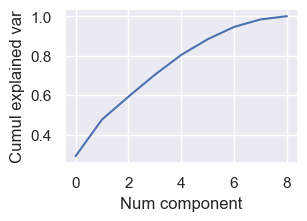

In [229]:
plt.figure(figsize=(3, 2))
plt.plot(range(0,9), pca.explained_variance_ratio_.cumsum()) #use number of atributes for the range of the plot
plt.xlabel('Num component')
plt.ylabel('Cumul explained var')

In [436]:
# Selecting 4 PCA
pca = PCA(n_components= 5) # Based on the previous plot
pca.fit(std)
scores_pca = pca.transform(std)

#### Selection of optimal number of clusters
Using the number of PCA components previously selected, calculate for different number of clusters the WCSS (within-cluster sums of squares) by k-means. The wcss represents for each cluster the distance of each point to the centroid of the cluster, thus the lower the WCSS value, the more proximal are the points in each cluster. 
A good rule of thumb to select the optimal number of clusters is to choose the number of clusters in which the curve of the plot creates an inflexion. 
It is recommended to maintain a value of random_state if changing the rest of parameters: PCA components and number of clusters.

In [438]:
wcss = []
for i in range(1,22):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42) 
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

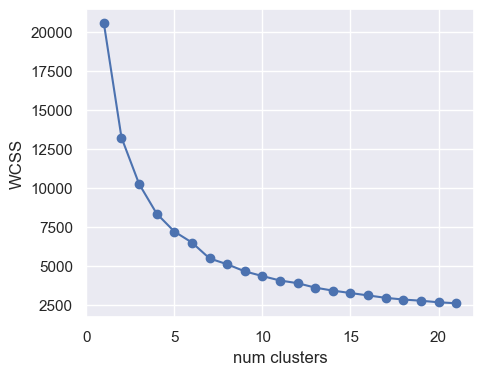

In [439]:
plt.figure(figsize = (5,4))
plt.plot(range(1, 22), wcss, marker='o')
plt.xlabel('num clusters')
plt.ylabel('WCSS')
plt.show()

In [441]:
kmeans_pca = KMeans(n_clusters=3, init='k-means++', random_state=42)

In [442]:
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=3, random_state=42)

The dataframe ratios_pca includes 'pca_kmeans_labels', which adds the cluster number that is associated to each object in the analysis.
For running the next cell, change the number in ratios_pc.columns.values[-3:] and include the number of PCA components selected, as well as writing 'Component_' for the same amount of PCA components. 

In [431]:
ratios_pca = pd.concat([ratios, pd.DataFrame(scores_pca)], axis=1)
ratios_pca.columns.values[-3:] = ['Component1', 'Component2', 'Component3']
ratios_pca['pca_kmeans_labels'] = kmeans_pca.labels_

#### Plotting the cells based on their values in the selected PCA components and colored by their cluster

In [ ]:
ratios_plot = ratios_pca[['gold_cyto_R',
                         'lyso_cyto_R',
                         'hetero_nuc_R',
                          'nuc_cell_R',
                         'mean_nuc_area_cyto_R',
                          'mean_nuc_aspect',
                         'mean_nuc_roundness',
                          'mito_cyto_R',
                         'mean_mito_area_cyto_R',
                         'mean_mito_roundness',
                          'mean_mito_aspect',
                         'ER_cyto_R',
                         'cell_roundness',
                          'cell_aspect',
                         'pca_kmeans_labels'
                            ]]

In [ ]:
cmap = {0:'cyan',
       1:'#aaaaff', #purple
       2:'red', 
       3:'green',
       4: 'black',
       5: 'orange'}

clabels = [cmap.get(k) for k in ratios_plot['pca_kmeans_labels']]

Text(0.5, 1.0, 'clusters by pca')

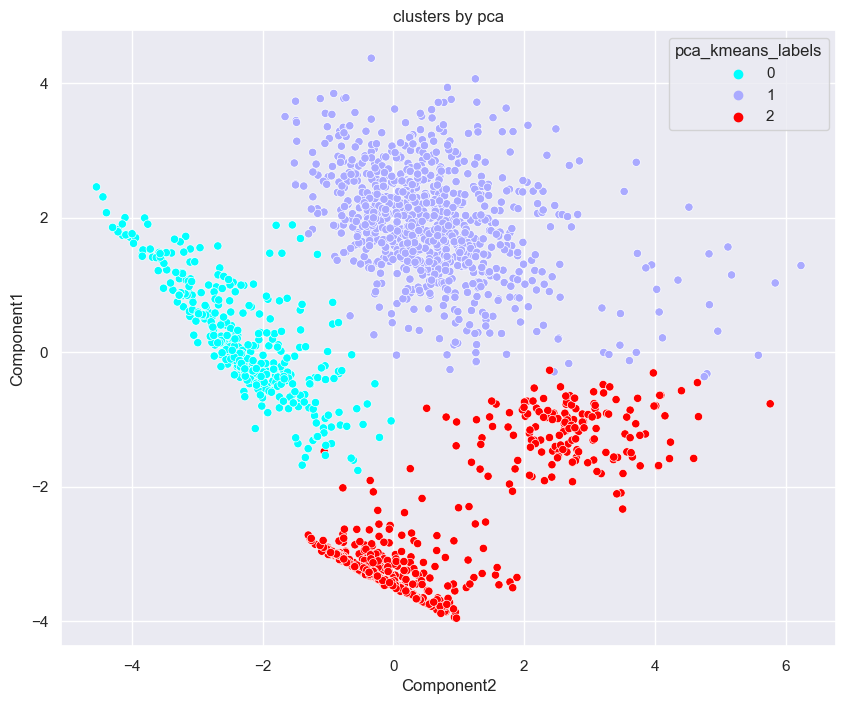

In [448]:
x_axis = ratios_pca['Component2']
y_axis = ratios_pca['Component1']
plt.figure(figsize=(10,8))
sns.scatterplot(data=ratios_pca, x='Component2', y='Component1', hue='pca_kmeans_labels', palette=cmap)

plt.title('clusters by pca')
#plt.savefig('noround_3pca_4clusters_42.png')

#### Extracting the implication of each feature in each of the PCA components

In [487]:
from sklearn import preprocessing
scaled_ratios = pd.DataFrame(preprocessing.scale(ratios),columns = ratios.columns) 

# PCA
pca = PCA(n_components=4)
pca.fit_transform(scaled_ratios)

array([[-0.20393522, -1.04407739,  1.21026186, -0.22873805],
       [ 2.52766823,  2.04578159, -0.47170933, -0.65992439],
       [-3.5035342 ,  1.11492018,  1.74921295, -0.85182451],
       ...,
       [ 0.92699618,  0.83020421,  2.0221353 ,  0.98268292],
       [ 0.91993014,  0.39901696,  1.60949456,  2.88271362],
       [ 0.90175315,  0.18630838,  1.97667688,  2.6219664 ]])

In [489]:
components = pd.DataFrame(pca.components_,columns=scaled_ratios.columns,index = ['PC-1','PC-2', 'PC-3', 'PC-4'])
#adjust according to number of PCA selected

In [490]:
components.to_excel("pca_4components_5cluster.xlsx")

#### Plot each of the features in the analysis against each other colored according to the cluster number

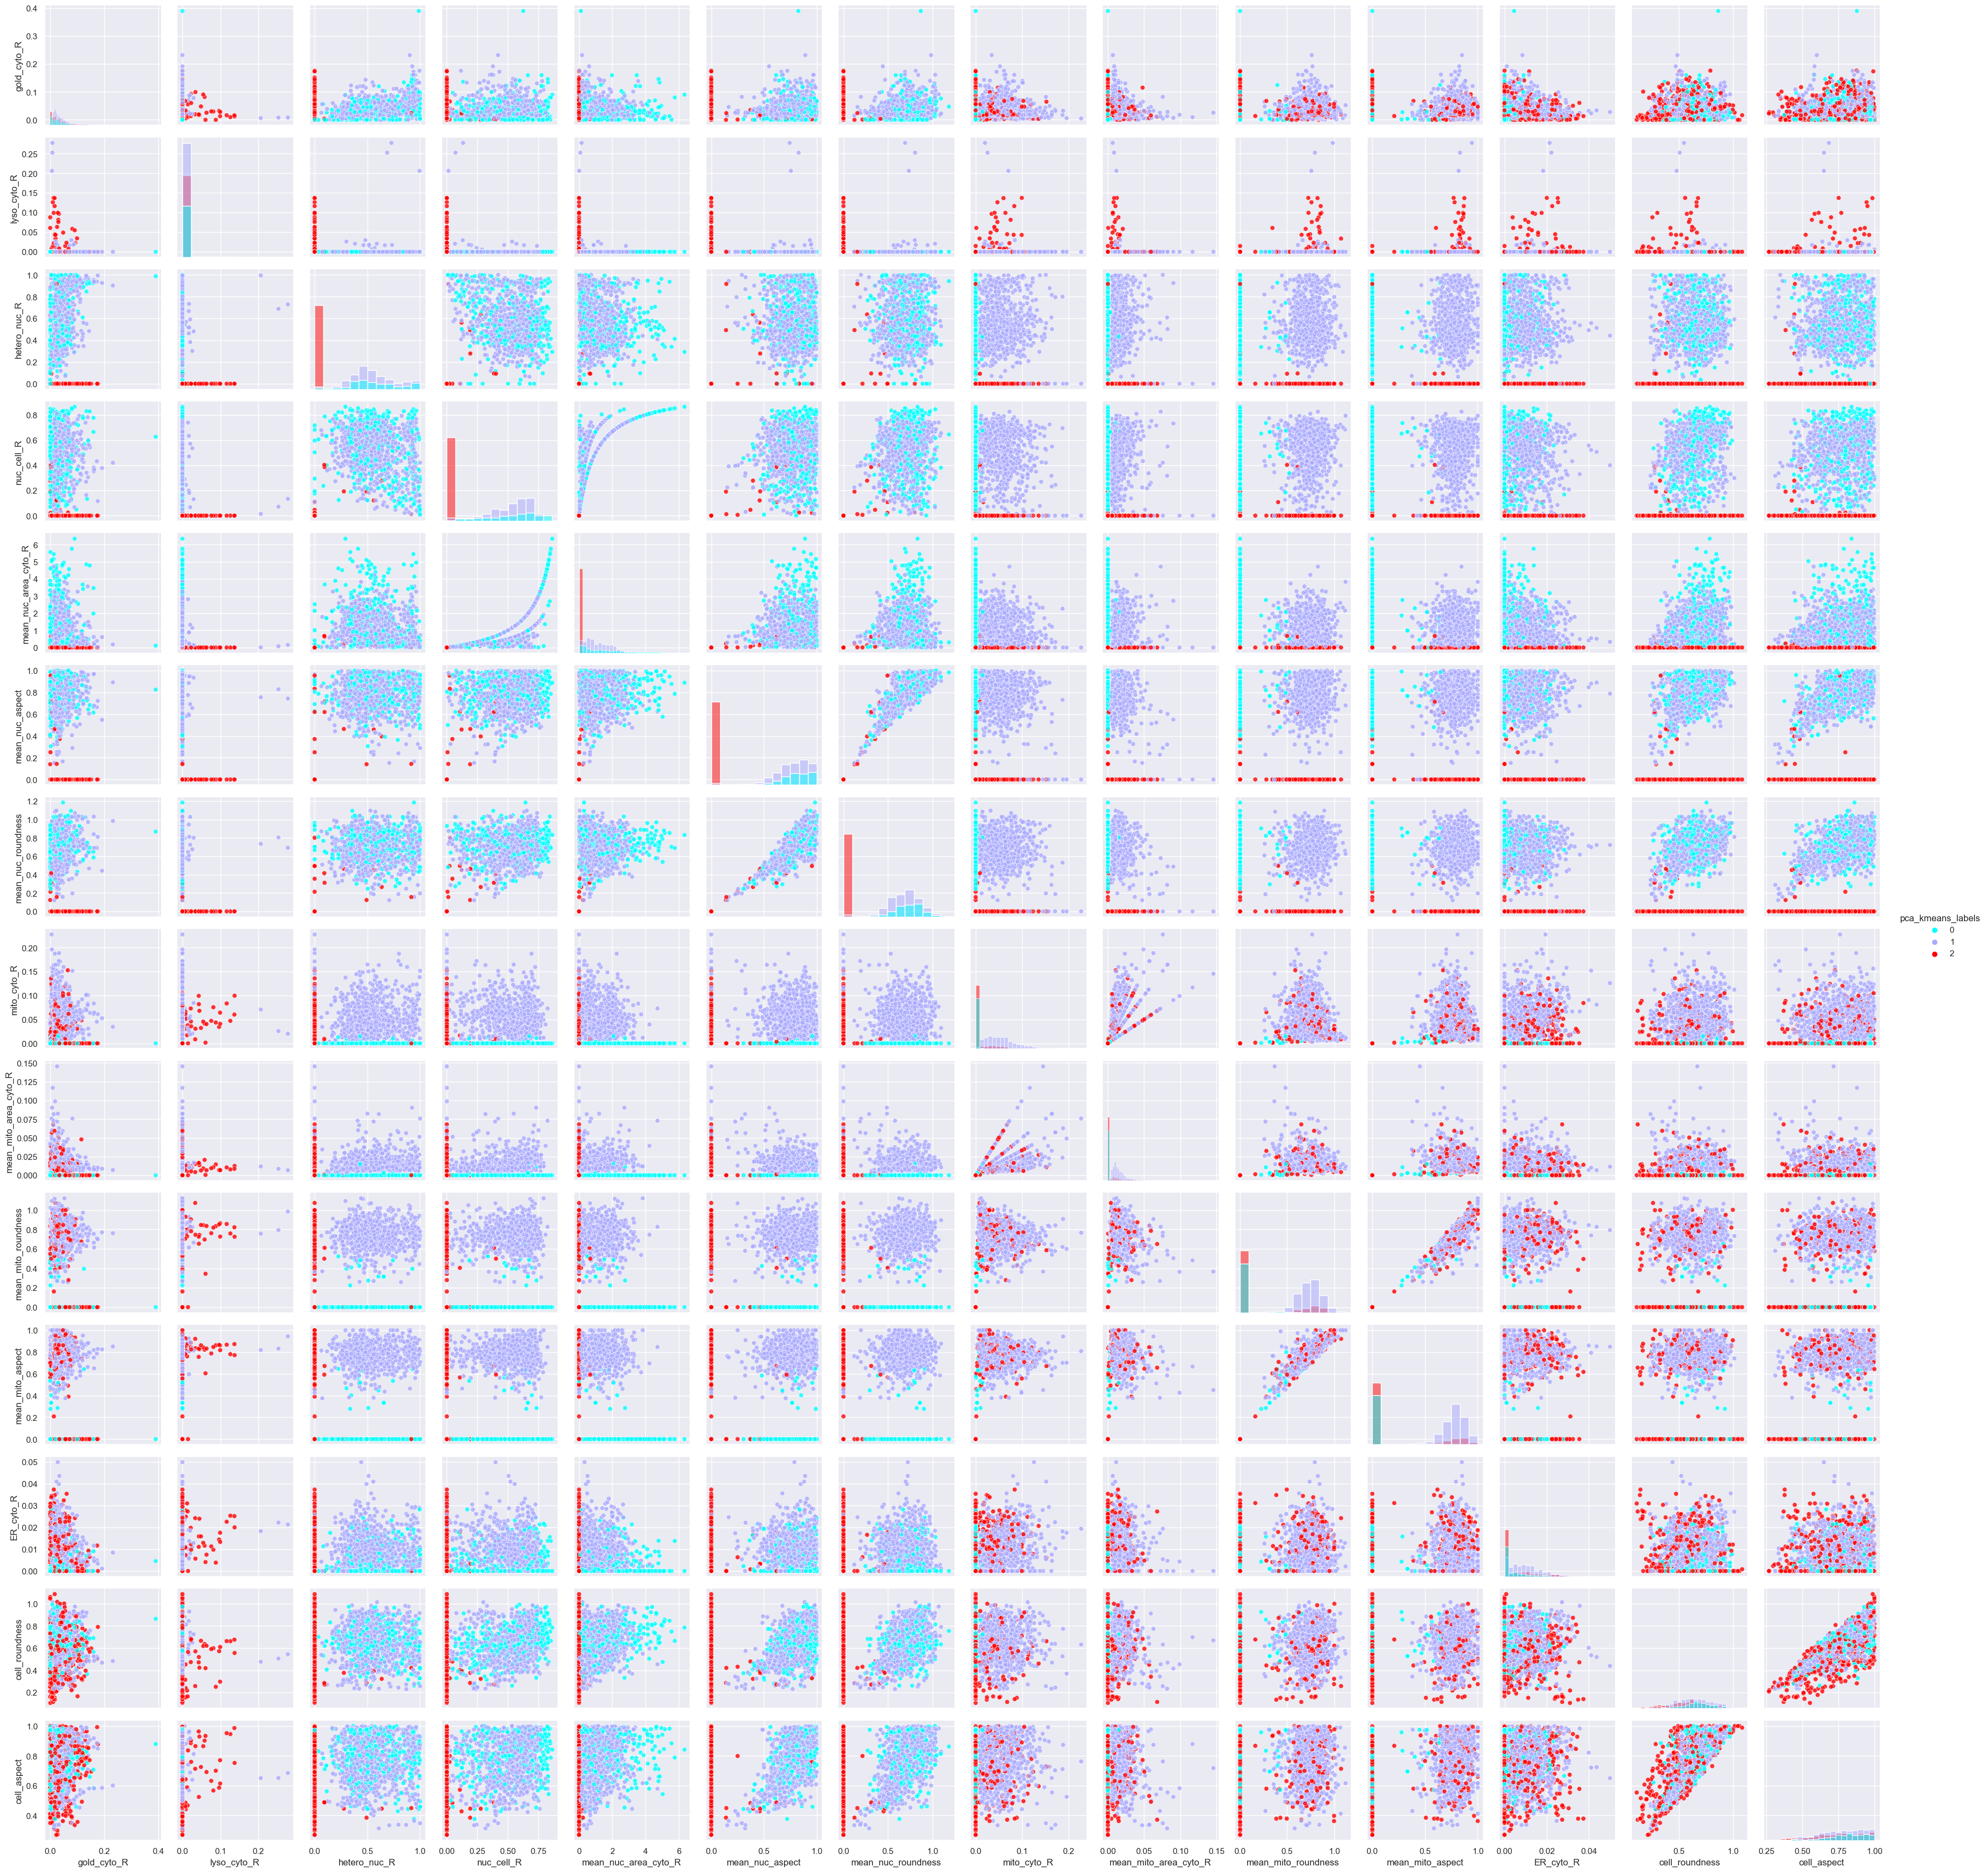

In [447]:
sns.set(rc={'figure.figsize':(100,120)})
g = sns.PairGrid(ratios_plot,
                 hue='pca_kmeans_labels',
                 palette=cmap
                )

g.map_offdiag(sns.scatterplot, alpha=0.8)
g.map_diag(sns.histplot)
g.add_legend()
plt.savefig('ratios_plot_all_5pca_3clusters_2.png')